# Modelling of France Accidents

**Cohort:** mar23_accidents

**Author:** Tobias Schulze

**Date:** 22 Oktober 2023



## Loading of required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import re
import pickle
import warnings
import time
import shap
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from datetime import datetime, timedelta
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from matplotlib import pyplot

## Importing the data

In [2]:
df = pd.read_csv('./data/231018_clean_table_for_analysis.csv', low_memory = False, index_col = 0)

## Data description
### Data

In [3]:
df.head()

,place,catu,sexe,an_nais,trajet,locp,an,mois,jour,lum,...,holiday,datetime,timestamp,actp,num_veh,hrmn,grav,etatp,hour_of_day,day_of_week
Num_Acc,,,,,,,,,,,,,,,,,,,,,
201900000001,2.0,2,2,2002,0.0,-1.0,2019,11,30,4,...,NaN,2019-11-30 01:30:00,1.575074e+09,0,14,90,3,0,1,Saturday
201900000001,1.0,1,2,1993,5.0,-1.0,2019,11,30,4,...,NaN,2019-11-30 01:30:00,1.575074e+09,0,14,90,3,0,1,Saturday
201900000001,1.0,1,1,1959,0.0,-1.0,2019,11,30,4,...,NaN,2019-11-30 01:30:00,1.575074e+09,0,0,90,0,0,1,Saturday
201900000002,1.0,1,2,1994,0.0,-1.0,2019,11,30,3,...,NaN,2019-11-30 02:50:00,1.575079e+09,0,0,170,3,0,2,Saturday
201900000003,1.0,1,1,1996,0.0,-1.0,2019,11,28,1,...,NaN,2019-11-28 15:15:00,1.574950e+09,1,0,915,0,0,15,Thursday


### Data types

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2421684 entries, 201900000001 to 201800055766
Data columns (total 43 columns):
 #   Column       Dtype  
---  ------       -----  
 0   place        float64
 1   catu         int64  
 2   sexe         int64  
 3   an_nais      int64  
 4   trajet       float64
 5   locp         float64
 6   an           int64  
 7   mois         int64  
 8   jour         int64  
 9   lum          int64  
 10  agg          int64  
 11  int          int64  
 12  atm          float64
 13  col          float64
 14  dep          int64  
 15  catr         float64
 16  circ         float64
 17  nbv          float64
 18  vosp         float64
 19  prof         float64
 20  plan         float64
 21  surf         float64
 22  infra        float64
 23  situ         float64
 24  senc         float64
 25  catv         int64  
 26  occutc       float64
 27  obs          float64
 28  obsm         float64
 29  choc         float64
 30  manv         float64
 31  date         

### Missing data

In [5]:
df.isna().sum()

place                0
catu                 0
sexe                 0
an_nais              0
trajet               0
locp                 0
an                   0
mois                 0
jour                 0
lum                  0
agg                  0
int                  0
atm                  0
col                  0
dep                  0
catr                 0
circ                 0
nbv                  0
vosp                 0
prof                 0
plan                 0
surf                 0
infra                0
situ                 0
senc                 0
catv                 0
occutc               0
obs                  0
obsm                 0
choc                 0
manv                 0
date                 0
is_holiday           0
holiday        2367768
datetime             0
timestamp            0
actp                 0
num_veh              0
hrmn                 0
grav                 0
etatp                0
hour_of_day          0
day_of_week          0
dtype: int6

This data has no missing values, accept the `holiday` variable which contains the name of the holiday or NaN.

### Drop variables
The dataset contains still some variables that represent information represented by other variables or are a finer granulation. The latter might be added later, if the primary variable is relevant.

- `holiday`: classifies the holiday, but will be used only, if `is_holiday` is relevant

In [6]:
columns_drop = ['holiday']

df.drop(columns = columns_drop, inplace = True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2421684 entries, 201900000001 to 201800055766
Data columns (total 42 columns):
 #   Column       Dtype  
---  ------       -----  
 0   place        float64
 1   catu         int64  
 2   sexe         int64  
 3   an_nais      int64  
 4   trajet       float64
 5   locp         float64
 6   an           int64  
 7   mois         int64  
 8   jour         int64  
 9   lum          int64  
 10  agg          int64  
 11  int          int64  
 12  atm          float64
 13  col          float64
 14  dep          int64  
 15  catr         float64
 16  circ         float64
 17  nbv          float64
 18  vosp         float64
 19  prof         float64
 20  plan         float64
 21  surf         float64
 22  infra        float64
 23  situ         float64
 24  senc         float64
 25  catv         int64  
 26  occutc       float64
 27  obs          float64
 28  obsm         float64
 29  choc         float64
 30  manv         float64
 31  date         

## Data preparation
### Transform data types
#### Date and time variables
The date and time variables are maybe important as grouping variables or as contrains for time dependent severity of accidents.

_Problem_:

Due to the export to `csv`, the `datatime` data time is lost and thus, it is required to assign it again.

**Steps:**
1. Transform `date` and `hrmn` to `datetime` type.nais` to integer and `date` to `date`.

In [8]:
# Fixing the hrmn issue:
# Transform `date`
df = df.assign(date = pd.to_datetime(df['date']))
df = df.assign(hrmn = pd.to_datetime(df['hrmn']))

In [9]:
df['date'] = df.apply(lambda x: int(x['date'].timestamp()), axis = 1)
df['hrmn'] = df.apply(lambda x: int(x['hrmn'].timestamp()), axis = 1)
le = LabelEncoder()
df['day_of_week'] = le.fit_transform(df['day_of_week'])

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2421684 entries, 201900000001 to 201800055766
Data columns (total 42 columns):
 #   Column       Dtype  
---  ------       -----  
 0   place        float64
 1   catu         int64  
 2   sexe         int64  
 3   an_nais      int64  
 4   trajet       float64
 5   locp         float64
 6   an           int64  
 7   mois         int64  
 8   jour         int64  
 9   lum          int64  
 10  agg          int64  
 11  int          int64  
 12  atm          float64
 13  col          float64
 14  dep          int64  
 15  catr         float64
 16  circ         float64
 17  nbv          float64
 18  vosp         float64
 19  prof         float64
 20  plan         float64
 21  surf         float64
 22  infra        float64
 23  situ         float64
 24  senc         float64
 25  catv         int64  
 26  occutc       float64
 27  obs          float64
 28  obsm         float64
 29  choc         float64
 30  manv         float64
 31  date         

The correlation matrix shows some intervariable correlations, but no real importance of variables to predict the target `fatal`. 

#### Aggregation and encoding of the target variable
In the previous notebook, we used the `grav` variable as is without any further processing. The modelling result was not satisfying. Therefore, it was decided to aggregate the four classes into two classes "severe" and "non-severe" encoded in `[1,0]`.

In [11]:
drop_cols = ['timestamp', 'datetime']
df.drop(drop_cols, axis = 1, inplace = True)

In [12]:
# Encoding
# grav encodes in 1=unscated, 2=killed, 3=hospitalized, 4=light injured.
# After first encoding in notebook 2, we created new classes as 0=unscated, 1=killed, 2=hospitalized, 3=light injured
# Thus [0,3] = 0, [2,3] = 1

df['severe'] = np.where(df['grav'].isin([1, 2]), 0, 1)

In [13]:
df.severe.unique()

array([1, 0])

The following visualisation shows the balance between the two classes. The dataset is much more balanced now compared to the four classes `grav`.

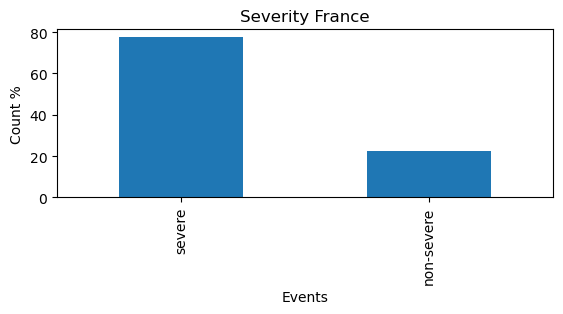

In [14]:
# test if the 
import matplotlib.pyplot as plt
# exploring severe cases in % 
event_counts = df['severe'].value_counts()
event_percentages = (event_counts / event_counts.sum()) * 100
plt.subplot(2,1,1)
event_percentages.plot.bar()
labels = ['severe','non-severe']
# Add labels and title to the plot
plt.xticks(range(len(event_counts)), labels)
plt.xlabel('Events')
plt.ylabel('Count %')
plt.title('Severity France')
# Display the plot
plt.show()

### Preparation of the training and test datasets
#### Split data
The dataset is split by year slides. We decided to drop the Covid-19 years 2020-21. The years 2005 to 2017 are selected for the train dataset and the years 2018 and 2019 for the test dataset. Furthermore, the `grav` variable is dropped because it is encoded in `severe`.


In [15]:
df.drop('grav', axis = 1, inplace = True)

In [16]:
# split the dataset to train and test data
X_train = df.loc[df['an'] < 2018]
X_train = X_train.drop('severe', axis = 1)

X_test = df[(df['an'] >= 2018) & (df['an'] < 2020)]
X_test = X_test.drop('severe', axis = 1)

y_train = df['severe'].loc[df['an'] < 2018]
y_test = df['severe'][(df['an'] >= 2018) & (df['an'] < 2020)]


#### Data scaling
Decision trees are not sensitive to different scales and thus scaling is not required.

### Modelling the data using a XGBoost Classification Model with Tree-based Parzen Estimators optimisation
The Tree-based Parzen Estimator (TPE) [1] optimisation combines a Bayesian Sequential Model Based Optimisation (SMBO) and a random search on the hyperparemeter grid[2]. While the random search is a static approach, the SMBO optimises the model using prior runs to determine future points of exploration.

The package `hyperopt` [4] is used for optimisation. The hyperparameter optimisation code is written based on ideas in [5].

#### The tuning space
`hyperopt` uses a specific format of parameters expressions [7]. Hints on the parameter ranges are given in [1,5,7].

The `booster` in this first model is `gbtree`. The evaluation metric is `logloss` or `auc`[8].

Another classification method is Dropout with Multiple Additive Regression Trees (`dart`)[9], which is not used here.

The metric used is `mlogloss` (as a special case of `logloss`). The reason is that `logloss` is an absolute measure of the quality of the classification, while `auc` is a simple ranking function [10]. `logloss` is discussed as better performing with imbalanced datasets [11].


In [17]:
# Create the tuning space
booster = 'gbtree'
eval_metric = 'logloss'

tuning_space={
    'eta': hp.uniform('eta', 0, 1),
    'max_depth': hp.quniform('max_depth', 3, 10, 1),
    'gamma': hp.uniform ('gamma', 0, 10),
    'reg_alpha' : hp.uniform('reg_alpha', 0, 100),
    'reg_lambda' : hp.uniform('reg_lambda', 0, 10),
    'colsample_bytree' : hp.uniform('colsample_bytree', 0, 1),
    'colsample_bylevel' : hp.uniform('colsample_bylevel', 0, 1),
    'colsample_bynode' : hp.uniform('colsample_bynode', 0, 1),
    'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
    'n_estimators': hp.quniform('n_estimators', 10, 1000, 1), # default is 100, so we try to check in the one magnitude space
    'seed': 123,
    'early_stopping_rounds': 10, # stop tuning early to avoid overfitting
    'objective': 'binary:logistic',
    'subsample': hp.uniform('subsample', 0, 1)
    }

tuning_space.update({'scale_pos_weight': hp.uniform('scale_pos_weight', 0, 2)}) # helps in auc
tuning_space.update({'max_delta_step': hp.uniform('max_delta_step', 0, 2)}) # helps in auc
tuning_space.update({'eval_metric': eval_metric})
tuning_space.update({'booster': booster})


#### The tuning function
The following function integrates all steps required for the hyperoptimization tuning. The results are stored in the model and the tuning score is printed per step.

In [18]:
# Function for the classification
def hp_xgbclass(space, X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test):
    """ Function for Bayesian hyperparameter optimisation of XGboost classification model.
    Accepts a parameter `space` and the training and testing data set.
        :param tuning_space: a catalog containing the parameters used for hyperparameter tuning, ranges given in hp objects
        :param X_train: accepts the train data
        :param X_test: accepts the test data
        :param X_eval: accepts the eval data used for optimisation
        :param y_train: accepts the train target
        :param y_test: accepts the test target
        :param y_eval: accepts the eval data used for optimisation
    """

    clf=xgb.XGBClassifier(
        eta = space['eta'],
        eval_metric = space['eval_metric'],
        booster = space['booster'],
        n_estimators = np.int64(space['n_estimators']),
        max_depth = np.int64(space['max_depth']),
        gamma = space['gamma'],
        reg_alpha = space['reg_alpha'],
        min_child_weight=np.int64(space['min_child_weight']),
        colsample_bytree=space['colsample_bytree'],
        colsample_bylevel=space['colsample_bylevel'],
        colsample_bynode=space['colsample_bynode'],
        early_stopping_rounds = space['early_stopping_rounds'],
        objective = space['objective'],
        max_delta_step = space['max_delta_step'],
        subsample = space['subsample']
    )
          
    clf.fit(X_train,
            y_train,
            eval_set = [(X_test, y_test)],
            verbose=False)
        
    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred > 0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK}

#### The tuning
In this section, the hyperparameter tuning is performed. The results are stored in the trial db and the hyperparameter file for later re-use. In case, the downstream analysis is changed, the model could be loaded in this section.

In [19]:
# Running the crossvalidation or load stored parameters

# lets check the run time
start_time = time.monotonic()

# Suppress warnings because of deprecated functions or parameters, we cannot influence
warnings.filterwarnings('ignore')

# Rerun (True) or get stored parameters (False)
cv_rerun = True

# define the stored files
out_file_trial = './data/XGboost_model/231027_XGboost_gbtree_logloss_trial_db_severe_raw'
out_file_params = './data/XGboost_model/231027_XGboost_gbtree_logloss_hyperparameters_severe_raw'


# rerun the crossvalidation
if (cv_rerun == True):
    trials = Trials()
    best_hyperparams = fmin(fn = hp_xgbclass,
                            space = tuning_space,
                            algo = tpe.suggest,
                            max_evals = 100,
                            trials = trials,
                            verbose=0
                           )
    # save the best parameters and the trials database
    with open(out_file_trial, 'wb') as f:
        pickle.dump(trials, f)

    with open(out_file_params, 'wb') as f:
        pickle.dump(best_hyperparams, f)

# get the stored hyperparameters
else:
    with open('./data/XGboost_model/231022_XGboost_gbtree_logloss_hyperparameters_severe_raw', 'rb') as f:
        best_hyperparams = pickle.load(f)

# Track the end of the tuning
end_time = time.monotonic()
print(timedelta(seconds=end_time - start_time))

SCORE: 0.840157570992324
SCORE: 0.8257903368635907
SCORE: 0.8294278123920372
SCORE: 0.8372348832314761
SCORE: 0.8394824936562586
SCORE: 0.8423098763814266
SCORE: 0.8337403652565493
SCORE: 0.8430286351921786
SCORE: 0.8361190201053915
SCORE: 0.8389742001326328
SCORE: 0.8297256406285367
SCORE: 0.838890808226413
SCORE: 0.8339428884573689
SCORE: 0.8350905199286801
SCORE: 0.830642951596955
SCORE: 0.8427427200851392
SCORE: 0.8425759362726994
SCORE: 0.832592733785238
SCORE: 0.8350865488855267
SCORE: 0.8430048089332587
SCORE: 0.8398637137989778
SCORE: 0.8390655341251594
SCORE: 0.815572842830083
SCORE: 0.8323624132823452
SCORE: 0.8377590609277151
SCORE: 0.8379576130853814
SCORE: 0.812014788164703
SCORE: 0.8387518217160466
SCORE: 0.8443787898643095
SCORE: 0.8449029675605485
SCORE: 0.841924685195554
SCORE: 0.8418532064187941
SCORE: 0.8432589556950716
SCORE: 0.8292570575364443
SCORE: 0.8417618724262677
SCORE: 0.8374453485186023
SCORE: 0.8396611905981582
SCORE: 0.8435011893274245
SCORE: 0.8434019132

In [20]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bylevel': 0.664455417077943, 'colsample_bynode': 0.7228243411782372, 'colsample_bytree': 0.5878014898100365, 'eta': 0.04491117791772439, 'gamma': 0.9626144829798879, 'max_delta_step': 0.297975875101572, 'max_depth': 10.0, 'min_child_weight': 4.0, 'n_estimators': 799.0, 'reg_alpha': 3.031779470616897, 'reg_lambda': 2.4582705678721024, 'scale_pos_weight': 0.6986869980145106, 'subsample': 0.6583957047074847}


In [21]:
xgb_2 = xgb.XGBClassifier(
    booster = tuning_space['booster'],
    eta = best_hyperparams['eta'],
    gamma = best_hyperparams['gamma'],
    max_depth = np.int64(best_hyperparams['max_depth']),
    min_child_weight = np.int64(best_hyperparams['min_child_weight']),
    reg_alpha = best_hyperparams['reg_alpha'],
    reg_lambda = best_hyperparams['reg_lambda'],
    eval_metric = tuning_space['eval_metric'],
    objective = tuning_space['objective'],
    seed = tuning_space['seed'],
    early_stopping_rounds = tuning_space['early_stopping_rounds'],
    n_estimators = np.int64(best_hyperparams['n_estimators']),
    subsample = best_hyperparams['subsample'],
    # scale_pos_weight = best_hyperparams['scale_pos_weight'],
    max_delta_step = best_hyperparams['max_delta_step'],
    colsample_bylevel = best_hyperparams['colsample_bylevel'],
    colsample_bynode = best_hyperparams['colsample_bynode'],
    colsample_bytree = best_hyperparams['colsample_bytree']
)
  
xgb_1 = xgb_1.fit(X_train,
          y_train,
          eval_set = [(X_test, y_test)], 
          verbose = False)

# Track the end of the modelling
end_time = time.monotonic()
print(timedelta(seconds=end_time - start_time))

3:39:35.635106


In [22]:
y_pred = xgb_2.predict(X_test)
y_pred = [round(value) for value in y_pred]

print(classification_report(y_pred, y_test))

print(pd.crosstab(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.50      0.62      0.55     38274
           1       0.93      0.89      0.91    213549

    accuracy                           0.85    251823
   macro avg       0.71      0.75      0.73    251823
weighted avg       0.86      0.85      0.85    251823

severe      0       1
row_0                
0       23551   14723
1       23788  189761


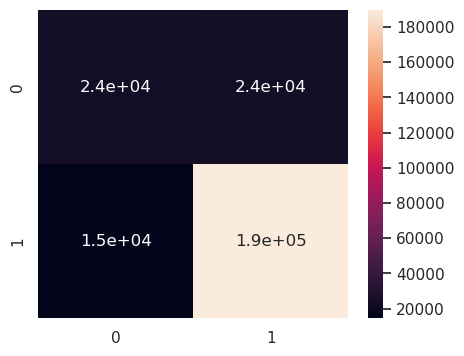

In [23]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize = (5, 4))
sns.set(font_scale=1)
sns.heatmap(cm, annot=True);

#### Variable importance and interpretation



<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

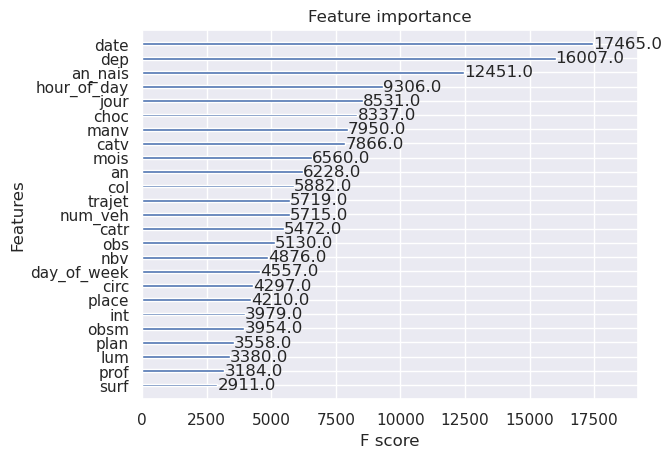

In [24]:
xgb.plot_importance(xgb_2, max_num_features=25)

In [26]:
# lets check the run time
start_time = time.monotonic()

thresholds = np.sort(xgb_2.feature_importances_)
for thresh in thresholds:
 # select features using threshold
 selection = SelectFromModel(xgb_2, threshold=thresh, prefit=True)
 select_X_train = selection.transform(X_train)
 # train model
 selection_model = xgb.XGBClassifier()
 selection_model.fit(select_X_train, y_train)
 # eval model
 select_X_test = selection.transform(X_test)
 y_pred = selection_model.predict(select_X_test)
 predictions = [round(value) for value in y_pred]
 accuracy = accuracy_score(y_test, predictions)
 print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))
# Track the end of the modelling
end_time = time.monotonic()
print(timedelta(seconds=end_time - start_time))

Thresh=0.000, n=39, Accuracy: 84.46%
Thresh=0.003, n=38, Accuracy: 84.46%
Thresh=0.003, n=37, Accuracy: 83.93%
Thresh=0.003, n=36, Accuracy: 83.95%
Thresh=0.003, n=35, Accuracy: 84.11%
Thresh=0.004, n=34, Accuracy: 84.25%


KeyboardInterrupt: 

In [ ]:
# lets check the run time
start_time = time.monotonic()

# compute the SHAP values for the linear model
explainer = shap.Explainer(xgb_2)
shap_values = explainer(X_train)

# Track the end of the shap modelling
end_time = time.monotonic()
print(timedelta(seconds=end_time - start_time))

In [ ]:
#Summarize the effects of features
shap.summary_plot(shap_values, X_train)

In [ ]:
#shap.force_plot(explainer.expected_value, shap_values[0], feature_names = explainer.feature_names)
shap.force_plot(explainer.expected_value, shap_values.values[0, :], X_train.iloc[0, :], matplotlib = True)

In [ ]:
#shap.force_plot(explainer.expected_value, shap_values[0], feature_names = explainer.feature_names)
shap.force_plot(explainer.expected_value, shap_values.values[1, :], X_train.iloc[0, :], matplotlib = True)

## References
[1] [Bergstra, J., Yamins, D., Cox, D. D. (2013) Making a Science of Model Search: Hyperparameter Optimization in Hundreds of Dimensions for Vision Architectures. TProc. of the 30th International Conference on Machine Learning (ICML 2013), June 2013, pp. I-115 to I-23.](https://proceedings.neurips.cc/paper_files/paper/2011/file/86e8f7ab32cfd12577bc2619bc635690-Paper.pdf)

[2] https://towardsdatascience.com/hyperopt-demystified-3e14006eb6fa

[3] https://xgboost.readthedocs.io/en/stable/tutorials/categorical.html

[4] https://github.com/hyperopt/hyperopt

[5] https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning

[6] https://github.com/hyperopt/hyperopt/wiki/FMin

[7] https://xgboost.readthedocs.io/en/stable/tutorials/param_tuning.html

[8] https://www.datamachines.io/blog/auc-vs-log-loss

[9] [Rashmi, K.V., Gilad-Bachrach (2015) DART: Dropouts meet Multiple Additive Regression Trees. arXiv:1505.01866v](https://doi.org/10.48550/arXiv.1505.01866)

[10] https://datamachines.com/blog/auc-vs-log-loss

[11] https://stats.stackexchange.com/questions/322408/logloss-vs-gini-auc

[12] https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/